# *Bike Sharing Demand - Kaggle Competition*

# Forecast use of a city bikeshare system

https://www.kaggle.com/c/bike-sharing-demand/data

Angela Gunn  
Sayantan Satpati  
Rajesh Thallam

## Import Libraries

pandas (http://pandas.pydata.org/)  
statsmodels (http://statsmodels.sourceforge.net/)  
pylab (http://wiki.scipy.org/PyLab)  
numpy   (http://www.numpy.org/)
matplotlib (http://matplotlib.org/)  
scipy.stats (http://docs.scipy.org/doc/scipy/reference/stats.html)
itertools (https://docs.python.org/2/library/itertools.html)
sklearn (http://scikit-learn.org/stable/)  
os (https://docs.python.org/2/library/os.html)

In [156]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import pearsonr

from datetime import datetime
import itertools

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor



import os

%matplotlib inline

# Data Import

##Data Fields
```
01. datetime    - hourly date + timestamp  
02. season      -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
03. holiday     - whether the day is considered a holiday
04. workingday  - whether the day is neither a weekend nor holiday
05. weather     - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
06. temp        - temperature in Celsius
07. atemp       - "feels like" temperature in Celsius
08. humidity    - relative humidity
09. windspeed   - wind speed
10. casual      - number of non-registered user rentals initiated
11. registered  - number of registered user rentals initiated
12. count       - number of total rentals
```

Note the Kaggle Test file does not have fields 10-12.

In [2]:
# import training data set
TRAIN = pd.read_csv("train.csv")
KAGGLE_TEST = pd.read_csv("test.csv")

In [3]:
#preview data
TRAIN.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [4]:
#preview data
KAGGLE_TEST.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# Exploratory Analysis
## i. Total bike rentals (count) distribution

In [5]:
#function processDateTime
# purpose: simple function to process datatetime
# df: data frame
# returns data frame
def processDateTime(df):  
    #Create new columns for day, month, year, hour
    df.index = pd.to_datetime(df['datetime']) # creating an index from the timestamp
    df['year'] = pd.DatetimeIndex(df['datetime']).year # year
    df['month'] = pd.DatetimeIndex(df['datetime']).month # month
    df['day'] = pd.DatetimeIndex(df['datetime']).day # day
    df['hours'] = pd.DatetimeIndex(df['datetime']).hour # hour
    df['dayofweek'] = pd.DatetimeIndex(df['datetime']).dayofweek # day of the week 0 = Monday to 6 = Sunday
    df['rownum'] = range(1,len(df)+1) 
    
    return df

#create a dataset for our exploration
explore_data = processDateTime(TRAIN)


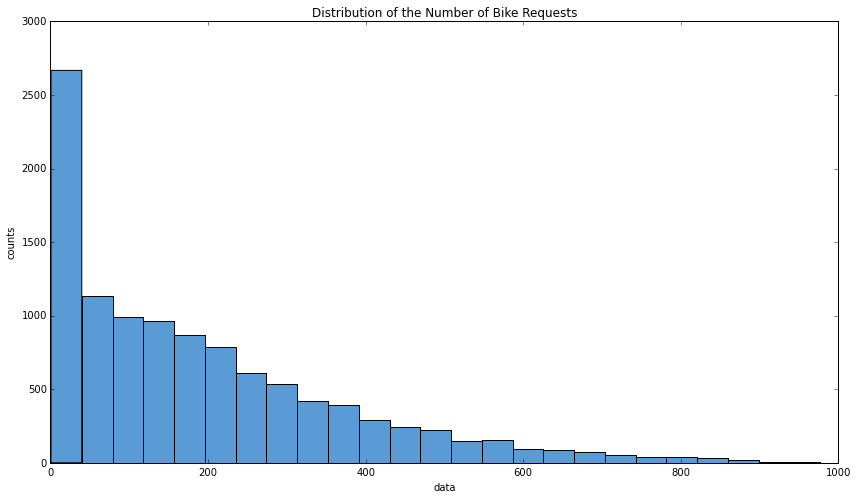

In [6]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.hist(TRAIN['count'], bins =25, color='#5b9bd5')
ax.set_xlabel('data')
ax.set_ylabel('counts')
ax.set_title("Distribution of the Number of Bike Requests")
plt.tight_layout()
plt.show()

## ii. Correlation

In [7]:
# correlation matrix between all variables
explore_data = explore_data.drop(['datetime'], 1)
correlation = explore_data.corr(method = 'pearson', min_periods = 1)
correlation.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hours,dayofweek,rownum
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.203093,0.035943,-0.003342,0.051814,0.231725,0.229206,0.004257,0.039942,0.207109,0.243796,0.260400,0.149583,0.204065,0.066533,0.129003,0.002998,0.234508
std,0.329031,0.259988,0.323837,0.271222,0.329199,0.330572,0.328674,0.271649,0.344592,0.341204,0.360708,0.310476,0.330331,0.241093,0.279946,0.316991,0.315502
min,-0.147121,-0.250491,-0.704267,-0.135918,-0.064949,-0.057473,-0.348187,-0.318607,-0.348187,-0.265458,-0.317371,-0.078606,-0.150192,-0.015877,-0.278011,-0.704267,-0.086245
25%,-0.004797,-0.007074,-0.008126,-0.055035,0.000295,-0.005215,-0.265458,-0.057473,0.043799,0.019111,0.011594,-0.004797,-0.002266,0.001132,-0.004818,-0.040235,-0.003490
50%,0.096758,0.000295,0.002780,-0.007890,0.145430,0.140343,-0.026507,0.007261,0.145241,0.169451,0.166862,0.001800,0.092722,0.009829,0.001132,-0.011070,0.173335
75%,0.258689,0.010675,0.024660,0.008879,0.318571,0.314635,0.032505,0.091052,0.462067,0.318571,0.394454,0.145241,0.257589,0.019111,0.146631,-0.002925,0.315425
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


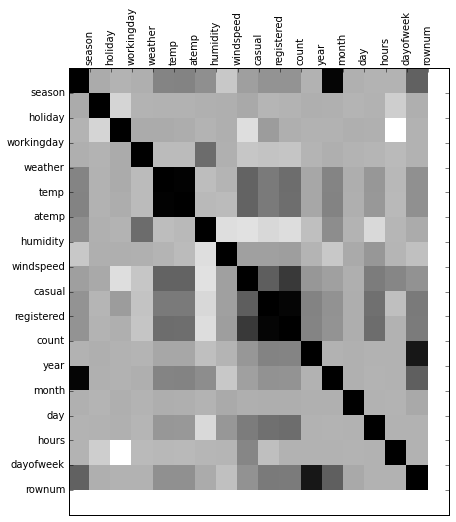

In [8]:
col_names = explore_data.columns.values.tolist() 
row_names = explore_data.columns.values.tolist()
data = correlation

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)
heatmap = ax.pcolor(data, cmap=plt.cm.Greys)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[0])+1, minor=False)
ax.set_yticks(np.arange(data.shape[1])+1, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_names, minor=False, rotation='vertical')
ax.set_yticklabels(col_names, minor=False, rotation='horizontal')
plt.show()


Some findings from the correlation matrix

- Well correlated 
  - season and month
  - season and weather  
  - season and temperature
  - season and humidity
  - working day and registered - (obvious) working days means commuters
  - atemp and weather
  - atemp and windspeed
  - atemp and registered
  - atemp and count
  - casual and holiday
  - casual and season
  - casual and windspeed
  - casual and year, hour, day and day of the week
  - casual and atemp
  - casual and median count
  - registered and season
  - registered and atemp
  - registered and windspeed
  - registered and year and hour
  - registered and median
  - count and season
  - count and weather
  - count and atemp
  - count and windspeed
  - count and year, hour
  - count and median

- Somewhat correlated
  - workingday and holiday
  - windspeed and day

###How about checking p-value? (data exploration is fun!)

In [9]:
n = len(explore_data.columns)
r = [pearsonr(explore_data[[i]], explore_data[[j]]) + (explore_data.columns.values[i], explore_data.columns.values[j]) for i in np.arange(n) for j in np.arange(n)]
r = np.array(r)
r[:, 1] = np.hstack(r[:, 1])
r[:, 0] = np.hstack(r[:, 0])

corr_m = pd.DataFrame(r[:,:], columns=['PearsonR', 'pValue', 'corX', 'corY'])
corr_m['significance'] = corr_m.apply(lambda row: '***' if row[1] <= .001 else '**' if row[1] <= .01 else '*' if row[1] <= .01 else '-', axis=1)

corr_m.query(' PearsonR != 1 and significance != "-" and corX != "rownum" and corY != "rownum" and ( PearsonR >= 0.3 or PearsonR <= -0.3) ')

,PearsonR,pValue,corX,corY,significance
12,0.9715238,0,season,month,***
42,-0.319111,3.561967e-256,workingday,casual,***
49,-0.7042674,0,workingday,dayofweek,***
57,0.4062437,0,weather,humidity,***
73,0.9849481,0,temp,atemp,***
76,0.4670971,0,temp,casual,***
77,0.3185713,2.869679e-255,temp,registered,***
78,0.3944536,0,temp,count,***
89,0.9849481,0,atemp,temp,***
93,0.4620665,0,atemp,casual,***


And a few more fun charts!

These charts show the histogram on the diagonal, and scatter plots elsewhere against the variables on the axis. The graphs are symetrical on the diagonal axis.

This visual confirms some of our assumptions on the data.

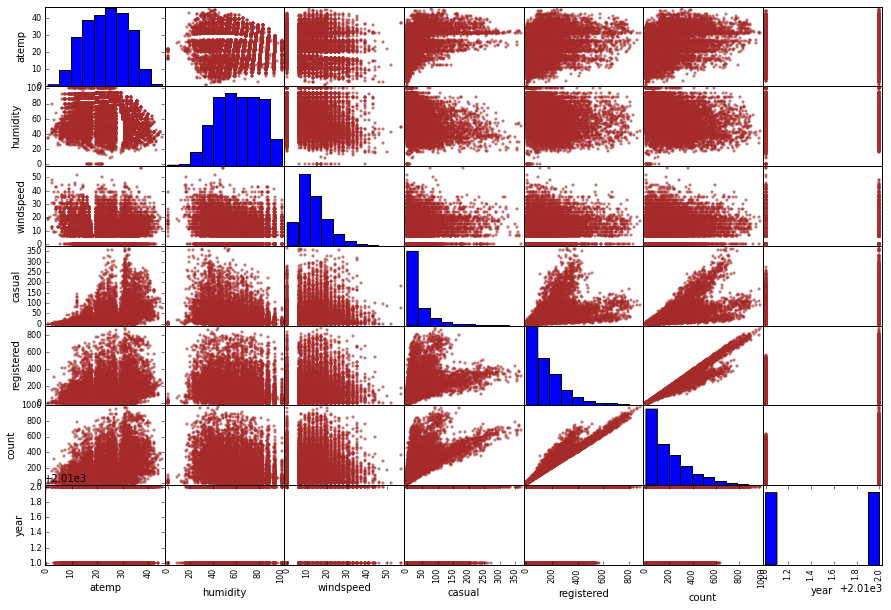

In [10]:
_ = pd.tools.plotting.scatter_matrix(explore_data.ix[:,5:12], figsize=(15,10), diagonal='hist', color='brown')

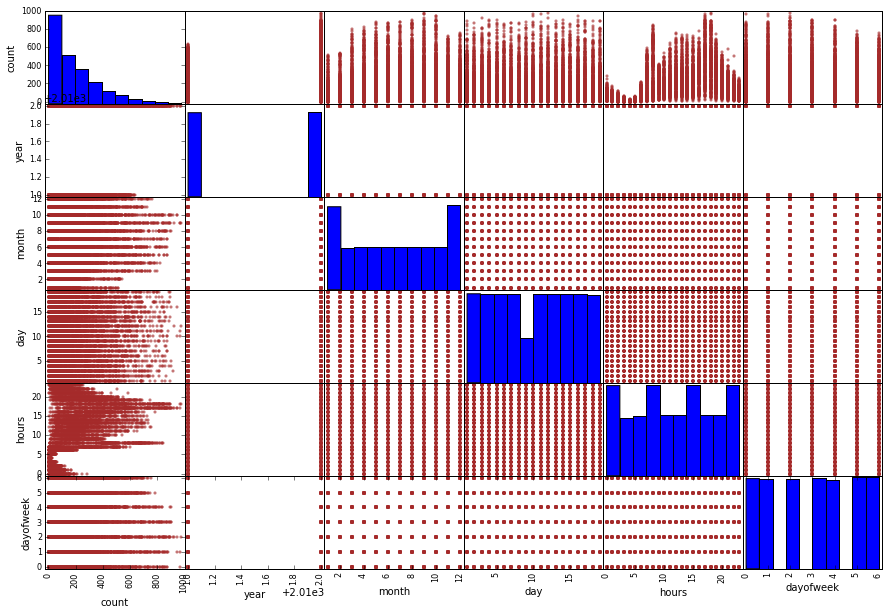

In [11]:
_ = pd.tools.plotting.scatter_matrix(explore_data.ix[:,10:16], figsize=(15,10), diagonal='hist', color='brown')

#### Why casual and registered users should be modeled separately?

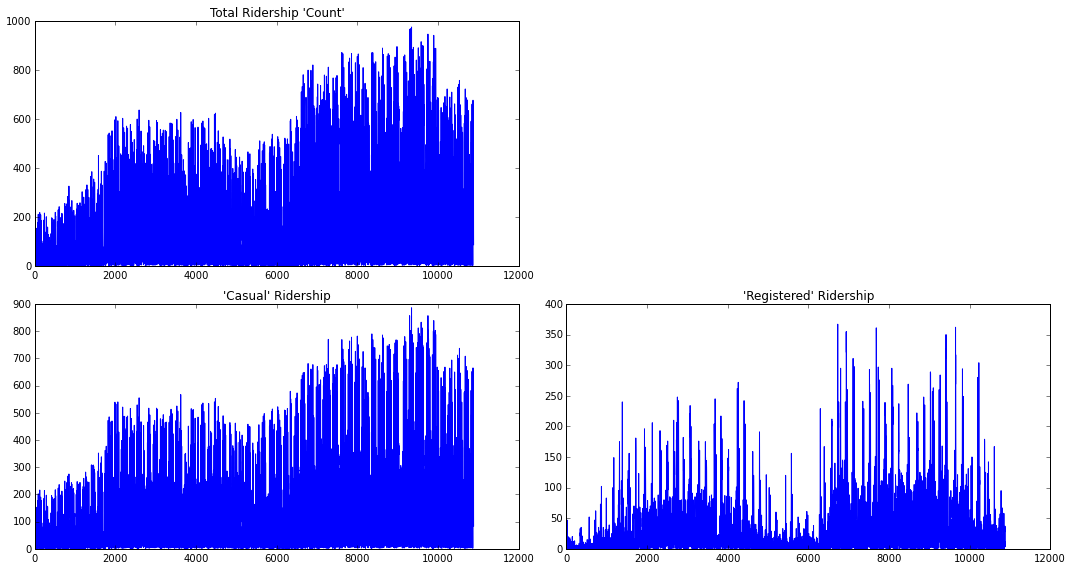

In [12]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(221); ax1.set_title("Total Ridership 'Count'")
ax1.plot(explore_data['count'])
ax2 = plt.subplot(223); ax2.set_title("'Casual' Ridership")
ax2.plot(explore_data['registered'])
ax3 = plt.subplot(224); ax3.set_title("'Registered' Ridership")
ax3.plot(explore_data['casual'])

plt.tight_layout()
plt.show()

The above charts show casual and registered ridership follows very different patterns.

## iii. Exploratory analysis

Here we will create a set of plots that will show patterns in the data

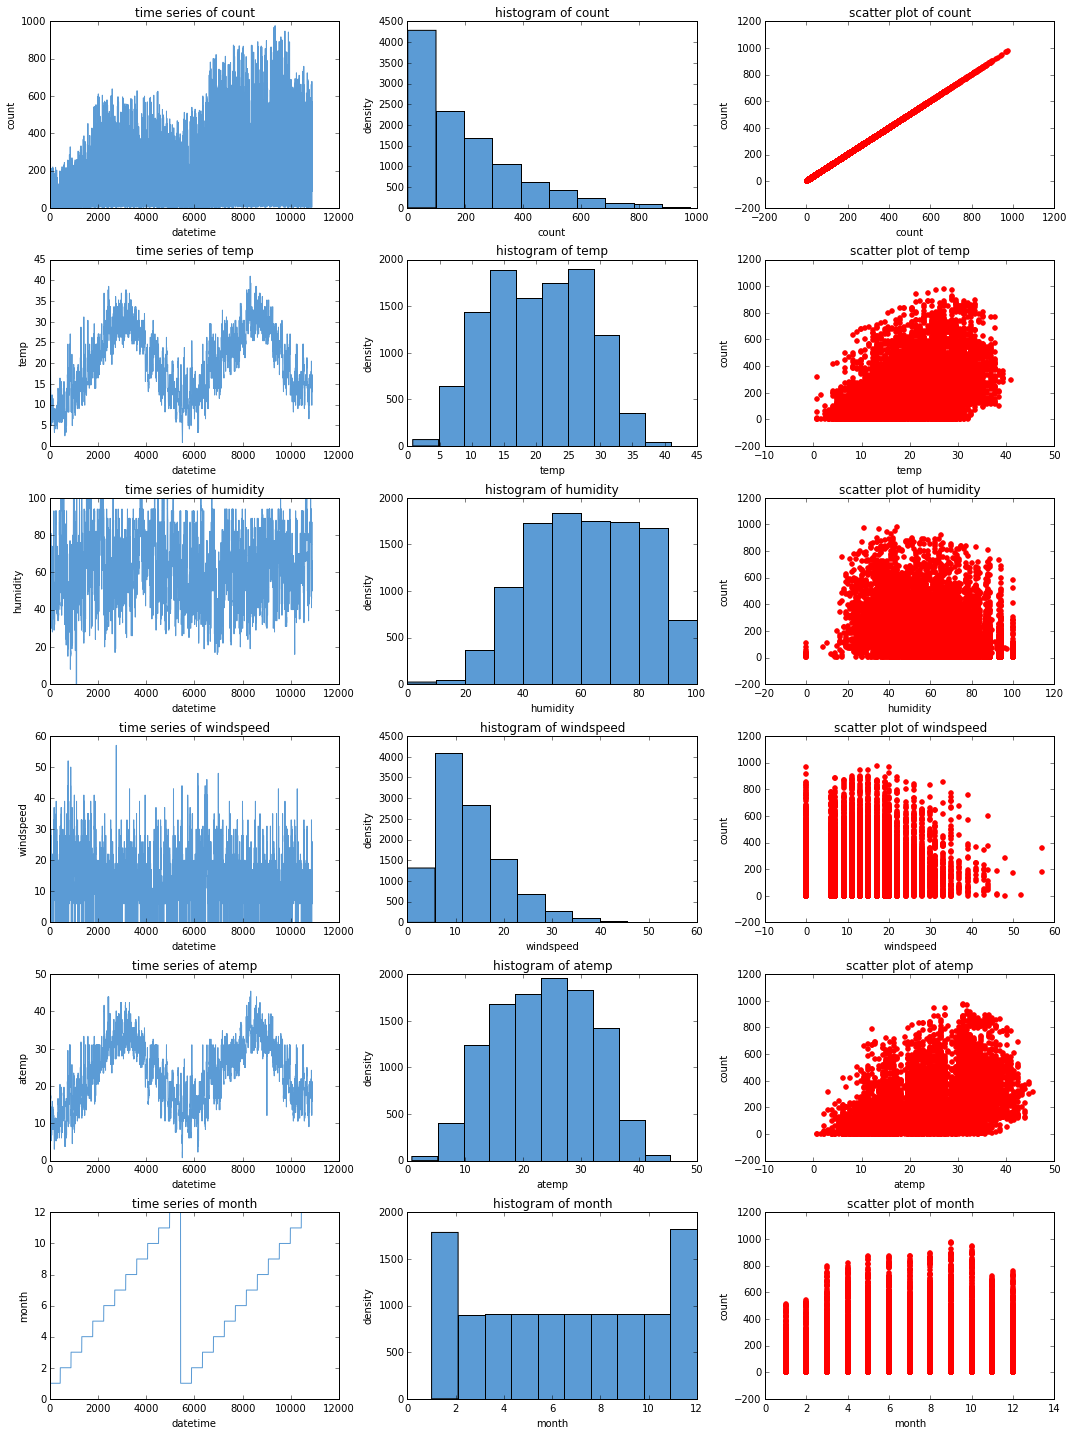

In [13]:
# data exploratory analysis
fig = plt.figure(figsize=(15,20))

pl.subplots_adjust(hspace=0.000)
number_of_subplots=18

col_names = ['count', 'temp', 'humidity', 'windspeed', 'atemp', 'month']
no_of_axes = 3

for v in np.arange(0, number_of_subplots, 3):
    ax1 = pl.subplot(number_of_subplots/3, 3, v+1)
    ax1.plot(explore_data[col_names[v/3]], color='#5b9bd5')
    ax1.set_xlabel("datetime")
    ax1.set_ylabel(col_names[v/3])
    ax1.set_title('time series of ' + col_names[v/3])
    
    ax2 = pl.subplot(number_of_subplots/3, 3, v+2)
    ax2.hist(explore_data[col_names[v/3]], color='#5b9bd5')
    ax2.set_xlabel(col_names[v/3])
    ax2.set_ylabel("density")
    ax2.set_title('histogram of ' + col_names[v/3])

    ax3 = pl.subplot(number_of_subplots/3, 3, v+3)
    ax3.scatter(explore_data[col_names[v/3]], explore_data['count'], color='red')
    ax3.set_xlabel(col_names[v/3])
    ax3.set_ylabel("count")
    ax3.set_title('scatter plot of ' + col_names[v/3])
    
plt.tight_layout()
#plt.savefig("../images/data_exploration_1.jpg", dpi=150)
plt.show()

## iv. Total rentals, registered and casual users

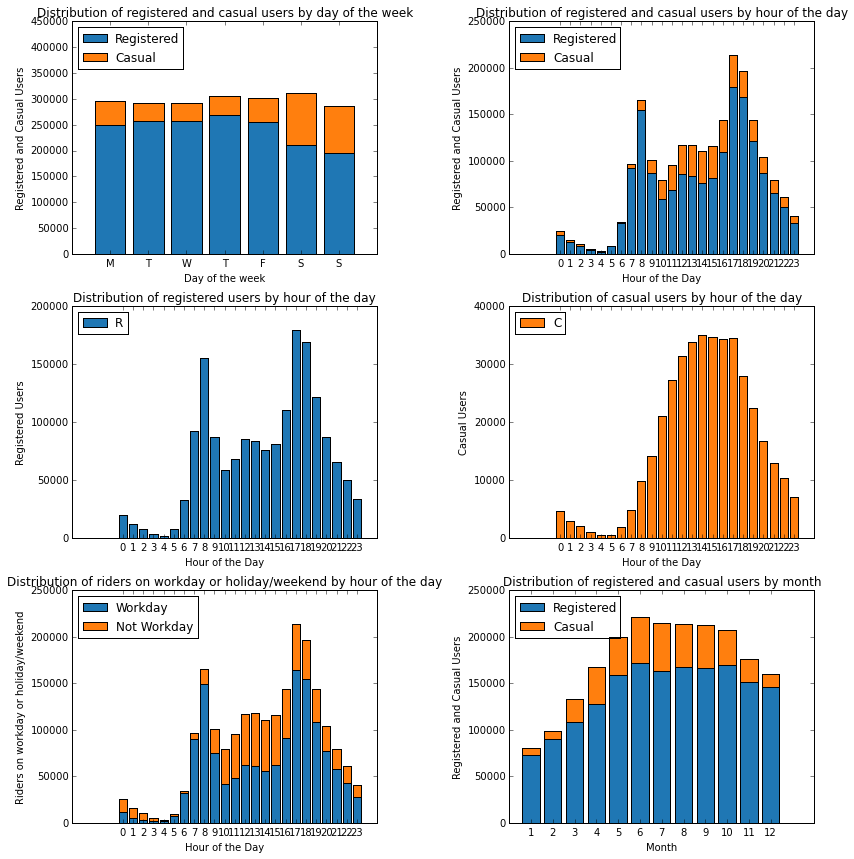

In [15]:
# analyze dependent variables
fig = plt.figure(figsize=(12, 12))

# Defining a color pattern based
colors = np.array([(31, 119, 180), (255, 127, 14)])/255.

plt.subplots_adjust(hspace = 0.000)

group = explore_data['dayofweek']
ind = range(7)
x_ticks = ('M', 'T', 'W', 'T', 'F', 'S', 'S')

df_reg = np.bincount(group, weights=explore_data['registered'])
df_cas = np.bincount(group, weights=explore_data['casual'])

ax1 = plt.subplot(3, 2, 1)
ax1.bar(ind, df_reg, color=colors[0], align='center')
ax1.bar(ind, df_cas, color=colors[1], bottom = df_reg, align='center')
ax1.set_xlabel("Day of the week")
ax1.set_ylabel("Registered and Casual Users")
ax1.set_title('Distribution of registered and casual users by day of the week')
plt.legend(labels = ('Registered', 'Casual'), ncol=1, loc='upper left')
ax1.set_yticks(np.arange(0, 500000, 50000))
plt.xticks(ind, ('M', 'T', 'W', 'T', 'F', 'S', 'S'), horizontalalignment = 'center')

group = explore_data['hours']
ind = range(24)
df_reg = np.bincount(group, weights=explore_data['registered'])
df_cas = np.bincount(group, weights=explore_data['casual'])

ax2 = plt.subplot(3, 2, 2)
ax2.bar(ind, df_reg, color=colors[0], align='center')
ax2.bar(ind, df_cas, color=colors[1], bottom = df_reg, align='center')
ax2.set_xlabel("Hour of the Day")
ax2.set_ylabel("Registered and Casual Users")
ax2.set_title('Distribution of registered and casual users by hour of the day')
plt.legend(labels = ('Registered', 'Casual'), ncol=1, loc='upper left')
ax2.set_yticks(np.arange(0, 300000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

ax3 = plt.subplot(3, 2, 3)
ax3.bar(ind, df_reg, color=colors[0], align='center')
ax3.set_xlabel("Hour of the Day")
ax3.set_ylabel("Registered Users")
ax3.set_title('Distribution of registered users by hour of the day')
plt.legend(labels = ('Registered'), ncol=1, loc='upper left')
ax3.set_yticks(np.arange(0, 250000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

ax4 = plt.subplot(3, 2, 4)
ax4.bar(ind, df_cas, color=colors[1], align='center')
ax4.set_xlabel("Hour of the Day")
ax4.set_ylabel("Casual Users")
ax4.set_title('Distribution of casual users by hour of the day')
plt.legend(labels = ('Casual'), ncol=1, loc='upper left')
ax4.set_yticks(np.arange(0, 50000, 10000))
plt.xticks(ind, horizontalalignment = 'center')

group_w = explore_data.loc[explore_data.workingday==1,'hours']
group_nw = explore_data.loc[explore_data.workingday==0,'hours']
ind = range(24)
df_workday = np.bincount(group_w, weights=explore_data.loc[explore_data.workingday==1, 'count'])
df_not_workday = np.bincount(group_nw, weights=explore_data.loc[explore_data.workingday==0, 'count'])

ax5 = plt.subplot(3, 2, 5)
ax5.bar(ind, df_workday, color=colors[0], align='center')
ax5.bar(ind, df_not_workday, color=colors[1], bottom = df_workday, align='center')
ax5.set_xlabel("Hour of the Day")
ax5.set_ylabel("Riders on workday or holiday/weekend")
ax5.set_title('Distribution of riders on workday or holiday/weekend by hour of the day')
plt.legend(labels = ('Workday', 'Not Workday'), ncol=1, loc='upper left')
ax5.set_yticks(np.arange(0, 300000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

group = explore_data['month']
ind = np.arange(1, 13, 1)
df_reg = np.bincount(group, weights=explore_data['registered'])
df_cas = np.bincount(group, weights=explore_data['casual'])

ax6 = plt.subplot(3, 2, 6)
ax6.bar(ind, df_reg[1:], color=colors[0], align='center')
ax6.bar(ind, df_cas[1:], color=colors[1], bottom = df_reg[1:], align='center')
ax6.set_xlabel("Month")
ax6.set_ylabel("Registered and Casual Users")
ax6.set_title('Distribution of registered and casual users by month')
plt.legend(labels = ('Registered', 'Casual'), ncol=1, loc='upper left')
ax6.set_yticks(np.arange(0, 300000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

plt.tight_layout()
#plt.savefig("../images/data_exploration_2.jpg", dpi=150)
plt.show()

Looking at the Registered Users and the Casual Users, we see another reason why registered and casual ridership should be modelled separately.

We also see the emergence of peaks when looking at the hour of the day. Let's see those peak hours closely for each day.

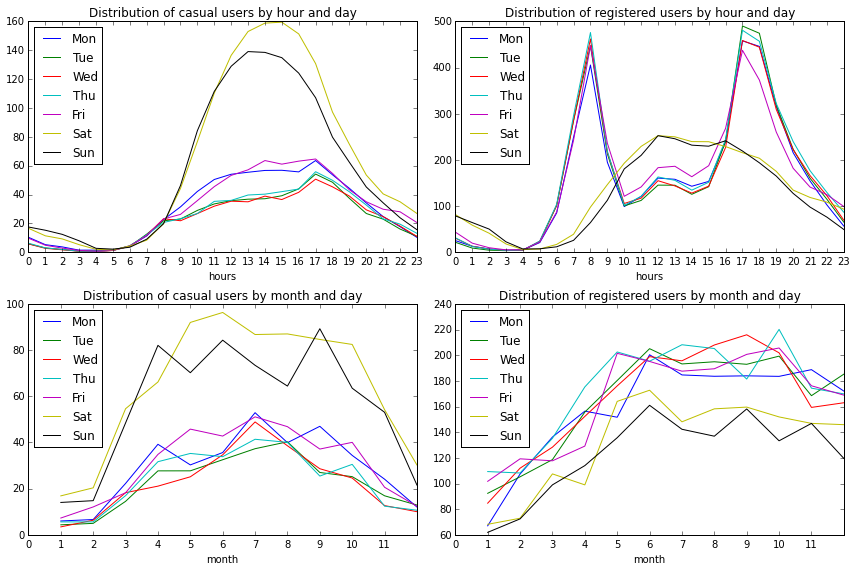

In [16]:
fig,axes = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
dy_cas = explore_data.groupby(['dayofweek','hours'])['casual'].mean()
dy_reg = explore_data.groupby(['dayofweek','hours'])['registered'].mean()

dy_cas_m = explore_data.groupby(['dayofweek','month'])['casual'].mean()
dy_reg_m = explore_data.groupby(['dayofweek','month'])['registered'].mean()


dy_cas_m = explore_data.groupby(['dayofweek','month'])['casual'].mean()
dy_reg_m = explore_data.groupby(['dayofweek','month'])['registered'].mean()

plt.sca(axes[0,0])
dy = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    dy_cas[i].plot(kind = 'line',label = dy[i])

axes[0,0].set_title('Distribution of casual users by hour and day')
plt.xticks(list(range(24)), horizontalalignment = 'center')
plt.legend(loc='upper left')

plt.sca(axes[0,1])
for i in range(7):
    dy_reg[i].plot(kind = 'line',label = dy[i])

axes[0,1].set_title('Distribution of registered users by hour and day')
plt.xticks(list(range(24)), horizontalalignment = 'center')
plt.legend(loc='upper left')


plt.sca(axes[1,0])
dy = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    dy_cas_m[i].plot(kind = 'line',label = dy[i])

axes[1,0].set_title('Distribution of casual users by month and day')
plt.xticks(list(range(12)), horizontalalignment = 'center')
plt.legend(loc='upper left')

plt.sca(axes[1,1])
for i in range(7):
    dy_reg_m[i].plot(kind = 'line',label = dy[i])

axes[1,1].set_title('Distribution of registered users by month and day')
plt.xticks(list(range(12)), horizontalalignment = 'center')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

The above charts clearly show the differences between registered and casual ridership, which supports our theory registered and casual ridership should be modeled separately.


What about ridership with temperature, humidity and windspeed?

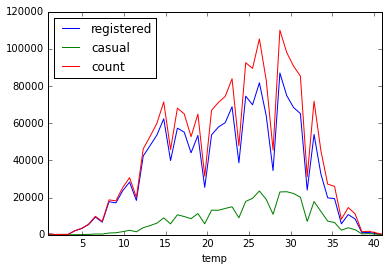

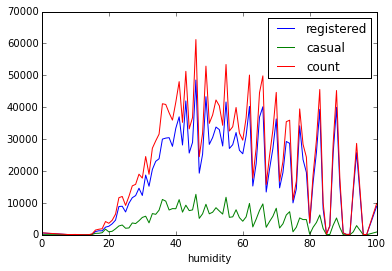

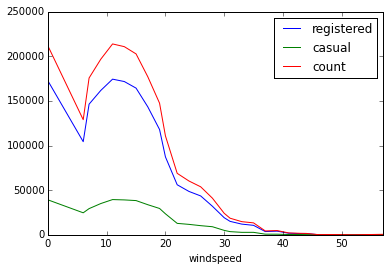

In [17]:
explore_data[['temp', 'registered', 'casual', 'count']].groupby('temp', sort=True).sum().plot()
explore_data[['humidity', 'registered', 'casual', 'count']].groupby('humidity', sort=True).sum().plot()
explore_data[['windspeed', 'registered', 'casual', 'count']].groupby('windspeed', sort=True).sum().plot()

*****
# Data Cleansing / Pre-Processing

We begin by determining the quartiles of the variable *count*  
We then set β = 2.25 and implement the formula _(Q3+β∗IQR,Q1−β∗IQR)_    
2.25 is the result of multiple trials.  
We then remove the outliers.

In [18]:
# Removing Outliers
q75, q25 = np.percentile(TRAIN['count'], [75 ,25])
iqr = q75 - q25 #the count between q75 an q25

print "Q1: {0}, Q3: {1}, IQR: {2}".format(q25, q75, iqr)

# (Q3+β∗IQR,Q1−β∗IQR)
beta = 2.25
lower = q25 - beta * iqr
upper = q75 + beta * iqr

print "Outliers: Less than {0}, Greater than {1}".format(lower, upper)
print "Original Training Set", TRAIN.shape
print "Training Set after Outlier Removal", TRAIN[(TRAIN['count'] > lower) & (TRAIN['count'] < upper)].shape

TRAIN_OR = TRAIN[(TRAIN['count'] > lower) & (TRAIN['count'] < upper)] #TRAIN with Outliers Removed

Q1: 42.0, Q3: 284.0, IQR: 242.0
Outliers: Less than -502.5, Greater than 828.5
Original Training Set (10886, 18)
Training Set after Outlier Removal (10825, 18)


In [19]:
#describe data
TRAIN.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hours,dayofweek,rownum
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,3.013963,5443.500000
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,2.004585,3142.661849
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,1.000000,2722.250000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,3.000000,5443.500000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,5.000000,8164.750000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,6.000000,10886.000000


Now we can create some functions to help us with the data cleansing/formatting.

In [20]:
#function peakhour
# purpose: return indicator if row represents a peak hour.
#          peak hours are from 7-9 and 16-20 on working days
# row: a row from the train table
# return: 1 or 0
def peakhour(row):
    if row['workingday'] == 1 and (7 <= row['hour'] <= 9 or 16 <= row['hour'] <= 20):
        return 1
    else:
        return 0

In [21]:
#function year_month
# purpose: return a number from 1 - 8 indicating the quarter for the 2 years
# row: a row from the train table
# return: a value from 1 - 8 (assumption is this should not return 0 unless there is an error)
def year_month(row):
    ret = 0
    if row['year'] == 2011:
        ret = 1
    if row['year'] == 2011 and row['month'] > 3:
        ret = 2
    if row['year'] == 2011 and row['month'] > 6:
        ret = 3
    if row['year'] == 2011 and row['month'] > 9:
        ret = 4
    if row['year'] == 2012:
        ret = 5
    if row['year'] == 2012 and row['month'] > 3:
        ret = 6
    if row['year'] == 2012 and row['month'] > 6:
        ret = 7
    if row['year'] == 2012 and row['month'] > 9:
        ret = 8
    return ret

Breaking the features into binary representation is often useful

For example, the weather variable has values 1, 2, 3, and 4. Each represents a type of weather. 
This can be better represented as binary variables. In this case, we create a variable *weather1* and set it to 1 if the weather variable is 1, and 0 otherwise.
This is like saying "Is it sunny today?" and answering "yes"(1) or "no"(0).

Another example is continuous variables. Instead of working with the many different temperatures we will likely get better results from grouping temperatures in ranges, then creating a binary variable for each of these ranges.



In [22]:
#function feature_extraction
# purpose: extract variables from continuous to discrete, or binary
# df: the dataframe to work on
# return: the modified dataframe

def feature_extraction(df):
    # Copy the DataFrame (TODO)
    dataframe = df.copy(deep=True)
    
    #Engineer Features from Data
    dataframe.index = pd.to_datetime(dataframe['datetime']) # creating an index from the timestamp
    
    #Break Date Time into multiple features: year, month, day, hour etc

    dataframe['year']= dataframe.index.year # year
    dataframe['month'] = dataframe.index.month # month
    dataframe['hour'] = dataframe.index.hour # hours
    dataframe['day'] = dataframe.index.dayofweek # day of week (Monday=0, Sunday=6)
    dataframe['dayofyear'] = dataframe.index.dayofyear
    dataframe['week'] = dataframe.index.week
    dataframe['quarter'] = dataframe.index.quarter 

    # Weather
    dataframe['weather1'] = dataframe['weather'].map(lambda x: 1 if x == 1 else 0)
    dataframe['weather2'] = dataframe['weather'].map(lambda x: 1 if x == 2 else 0)
    dataframe['weather3'] = dataframe['weather'].map(lambda x: 1 if x == 3 else 0)
    dataframe['weather4'] = dataframe['weather'].map(lambda x: 1 if x == 4 else 0)

    # Season
    dataframe['season1'] = dataframe['season'].map(lambda x: 1 if x == 1 else 0)
    dataframe['season2'] = dataframe['season'].map(lambda x: 1 if x == 2 else 0)
    dataframe['season3'] = dataframe['season'].map(lambda x: 1 if x == 3 else 0)
    dataframe['season4'] = dataframe['season'].map(lambda x: 1 if x == 4 else 0)
    
    # Temperature (espressed as discrete ranges)
    dataframe['temp1'] = dataframe['temp'].map(lambda x: 1 if x <= 12 else 0)
    dataframe['temp2'] = dataframe['temp'].map(lambda x: 1 if 13 <= x <= 25 else 0)
    dataframe['temp3'] = dataframe['temp'].map(lambda x: 1 if 26 <= x <= 33 else 0)
    dataframe['temp4'] = dataframe['temp'].map(lambda x: 1 if x >= 34  else 0)
    
    # Humidity (expressed as discrete ranges)
    dataframe['humidity1'] = dataframe['humidity'].map(lambda x: 1 if x <= 25 else 0)
    dataframe['humidity2'] = dataframe['humidity'].map(lambda x: 1 if 26 <= x <= 50 else 0)
    dataframe['humidity3'] = dataframe['humidity'].map(lambda x: 1 if 51 <= x <= 75 else 0)
    dataframe['humidity4'] = dataframe['humidity'].map(lambda x: 1 if x >= 76  else 0)

    # Sunday (Registered: Least # of Bikes Rented on Sundays)
    dataframe['sunday'] = dataframe['day'].map(lambda x: 1 if x == 6 else 0)
     # Sunday (Registered: Highest # of Bikes Rented on Sundays)
    dataframe['saturday'] = dataframe['day'].map(lambda x: 1 if x == 5 else 0)
    # Weekend
    dataframe['weekend'] = dataframe['day'].map(lambda x: 1 if x == 5 or x == 6 else 0)

    # Bucket Hours of Day
    #labels = ['0-3', '4-7', '8-11', '12-15', '16-19', '20-23']
    #lens['age_group'] = pd.cut(dataframe.hour, range(0, 23, 6), right=False, labels=labels)
    dataframe['hour_0_3'] = dataframe['hour'].map(lambda x: 1 if 0 <= x <= 3 else 0)
    dataframe['hour_4_7'] = dataframe['hour'].map(lambda x: 1 if 4 <= x <= 7 else 0)
    dataframe['hour_8_11'] = dataframe['hour'].map(lambda x: 1 if 8 <= x <= 11 else 0)
    dataframe['hour_12_15'] = dataframe['hour'].map(lambda x: 1 if 12 <= x <= 15 else 0)
    dataframe['hour_16_19'] = dataframe['hour'].map(lambda x: 1 if 16 <= x <= 19 else 0)
    dataframe['hour_20_23'] = dataframe['hour'].map(lambda x: 1 if 20 <= x <= 23 else 0)

    # Peak Hours (Morning & Eve) - Registered
    dataframe['peakhours'] = dataframe.apply(peakhour, axis=1) #peakhour previously defined function
    # Peak Hours - Rush Hour for Casual
    dataframe['peakhours_cas'] = dataframe['hour'].map(lambda x: 1 if 12 <= x <= 18 else 0)
    
    # Year/Month
    dataframe['year_month'] = dataframe.apply(year_month, axis=1) #year_month previously defined function
    
    # Year
    dataframe['year_2011'] = dataframe['year'].map(lambda x: 1 if x == 2011 else 0)
    dataframe['year_2012'] = dataframe['year'].map(lambda x: 1 if x == 2012 else 0)

    return dataframe

Our datasets now have a large number of variables. We will define a function to return the list of variables we are actually interested in.

In [23]:
#function feature_selection
# purpose: select features from data
# returns three arrays of strings: features, features_r and features_c
def feature_selection():
    
    # Separate Features for Count, Registered & Casual
    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'month', 'hour', 'day', 'dayofyear', 'week', 'quarter',
                'year_2011', 'year_2012', 'hour_16_19']

    features_r = ['season', 'workingday',
                  'temp', 'atemp', 'windspeed', 'humidity',
                  'weather1', 'weather2', 'weather3', 'weather4',
                  'temp1', 'temp2', 'temp3', 'temp4',
                'month', 'hour', 'day', 'dayofyear',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
                'year', 'year_month', 'sunday', 'peakhours']

    features_c = ['season', 'holiday', 
                  'temp', 'atemp', 'windspeed', 'humidity',
                  'weather1', 'weather2', 'weather3', 'weather4',
                  'temp1', 'temp2', 'temp3', 'temp4',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
                'month', 'hour', 'peakhours_cas', 'day', 'dayofyear',
                'year', 'year_month', 'weekend']

    return (features, features_r, features_c)

---
Now a couple of functions for the purpose of Kaggle Evaluations:

In [24]:
def RMSLE_score(Y_pred, Y_act):
    a = (np.log(Y_pred+1)-np.log(Y_act+1))
    b = 1./len(Y_pred)
    score = (b*sum(a**(2)))**(0.5)
    return score

def RMSE_score(log_Y_pred, log_Y_act):
    n = len(log_Y_pred)
    return np.sqrt(1/n*(np.sum((log_Y_pred-log_Y_act)**2)))

def inv_log(a):
    return np.exp(a)-1

In [53]:
#function generate_kaggle_submission
# purpose - generate file that meets requirements to submit to Kaggle.  Saves files to /submissions/f_name
# pred = predictions
# f_name = file name
def generate_kaggle_submission(pred, f_name):
    print "\n\nGenerating Kaggle Submission File: %s" % (f_name)
    print "Shape of Kaggle Test Set: ", KAGGLE_TEST.shape
    print "Shape of Kaggle Test Set Prediction: ", pred.shape
    print "preds: ", pred
    pred = np.rint(pred)
    pred = np.where(pred <= 0, 0, pred)
    df_pred = pd.DataFrame(pred, columns=['count'])

    df_dt = pd.DataFrame(KAGGLE_TEST['datetime'])
    df_dt.reset_index(drop=True, inplace=True)

    print "df_dt.head(): ",df_dt.head()
    print "df_dt.head(): ",df_pred.head()

    output = pd.concat([df_dt, df_pred], axis=1)
    print "Shape of Submission Dataframe: ", output.shape
    print "output.head():",output.head()

    file = [os.getcwd(),'/submissions/',f_name]
    output.to_csv("".join(file), index=False)
    
    
    
    

# Modeling

## Setup Data with Feature Extraction and reduce to Feature Sets

In [73]:
#Data Setup

#Create datasets with feature extraction applied 
TRAIN_FX = feature_extraction(TRAIN_OR) #TRAIN_OR is the training dataset with Outliers Removed
KAGGLE_TEST_FX = feature_extraction(KAGGLE_TEST)

#Get the feature sets
(features, features_r, features_c) = feature_selection()


### ALL USERS
#reduce to feature set
TRAIN_FX_FS = TRAIN_FX[features]
KAGGLE_TEST_FX_FS = KAGGLE_TEST_FX[features]

#create labels
Y = TRAIN_FX['count']
X = TRAIN_FX_FS.values
X1 = KAGGLE_TEST_FX_FS.values

### REGISTERED USERS
#reduce to feature set
TRAIN_FX_FS_R = TRAIN_FX[features_r]
KAGGLE_TEST_FX_FS_R = KAGGLE_TEST_FX[features_r]

#create labels
Y_R = TRAIN_FX['registered']
X_R = TRAIN_FX_FS_R.values
X1_R = KAGGLE_TEST_FX_FS_R.values

### CASUAL USERS
#reduce to feature set
TRAIN_FX_FS_C = TRAIN_FX[features_c]
KAGGLE_TEST_FX_FS_C = KAGGLE_TEST_FX[features_c]

#create labels
Y_C = TRAIN_FX['casual']
X_C = TRAIN_FX_FS_C.values
X1_C = KAGGLE_TEST_FX_FS_C.values

##Split Training Data into Test, Dev and Mini training

In [59]:
#working with only the full dataset at this point.
test_data, test_labels = X[9000:], Y[9000:]
dev_data, dev_labels = X[7000:9000], Y[7000:9000]
train_data, train_labels = X[:7000], Y[:7000]
print 'train data shape: ', train_data.shape
print 'train label shape:', train_labels.shape
print 'dev data shape: ', dev_data.shape
print 'dev label shape:', dev_labels.shape
print 'test data shape: ', test_data.shape
print 'test labels shape:', test_labels.shape

train data shape:  (7000, 17)
train label shape: (7000,)
dev data shape:  (2000, 17)
dev label shape: (2000,)
test data shape:  (1825, 17)
test labels shape: (1825,)


Let's define a function so we have consistent data output:

In [60]:
#function output_model_summary
# purpose: output the model results
# estimator: the estimator
# dev: the dev data set
# test: the test data set
def output_model_summary(estimator, dev_data, dev_labels, test_data=None, test_labels=None):
    #Prints Model Summary
    # The coefficients
    if 'coef_' in dir(estimator):
        print 'Coefficients: '
        print estimator.coef_
    
    if 'intercept_' in dir(estimator):
        print '\nIntercept: ', estimator.intercept_
        
    # The mean square error
    print ("Residual sum of squares: %.2f" % np.mean((np.rint(estimator.predict(dev_data)) - dev_labels) ** 2))
    
    # Explained variance score: 1 is perfect prediction
    print('[DEV]  R^2 - Variance score: %.2f' % estimator.score(dev_data, dev_labels))
    
    if test_data is not None:
        print('[TEST] R^2 - Variance score: %.2f' % estimator.score(test_data, test_labels))
    print "\n"
    


###Now let's work on a baseline Kaggle submission:

Our original baseline used a Linear Model without any polynomial features.

Here, we show the Linear Model the engineerd features we developed over the course of this project.

In [61]:
# Ordinary Least Squares (Baseline)
# Create linear regression object
ols = linear_model.LinearRegression()

# Train the model using the training sets
ols.fit(train_data, train_labels)

# Model Summary
output_model_summary(ols, dev_data, dev_labels, test_data, test_labels)

Coefficients: 
[  1.06034748e+00  -5.50965735e+00  -1.26809857e+00  -1.16322589e+01
  -2.34332283e+00   7.73110956e+00  -1.01510366e+00   2.23975872e-01
   9.20973522e+00   3.84197210e+00   8.22403270e-01   3.87082349e-03
  -8.98471581e-01   1.06034748e+00  -3.93606512e+01   3.93606512e+01
   1.25817905e+02]

Intercept:  18.9069036244
Residual sum of squares: 28398.26
[DEV]  R^2 - Variance score: 0.36
[TEST] R^2 - Variance score: 0.35




In [62]:
# Generate Kaggle Baseline
# Train the model using the entire data set
ols.fit(X, Y)
pred = ols.predict(X1)
generate_kaggle_submission(pred, "baseline.csv")



Generating Kaggle Submission File: baseline.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
preds:  [ -1.96859908e+01  -1.15336471e+01  -6.56880331e+00 ...,  -6.07169666e+13
  -6.07169666e+13  -6.07169666e+13]
df_dt.head():                datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
df_dt.head():     count
0      0
1      0
2      0
3      0
4      3
Shape of Submission Dataframe:  (6493, 2)
output.head():               datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00      3


The submission as generated here puts us in absolute last place (3252). We can only do better from here!

***
#Testing Various Models

##i) Linear Regressions

###a) Ridge Regression

In [85]:
# Ridge Regression
clf = linear_model.RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0])

# Train the model using the training sets
clf.fit(train_data, train_labels)
R_coef = clf.coef_
R_score = clf.score(dev_data, dev_labels)

# Model Summary
output_model_summary(clf, dev_data, dev_labels, test_data, test_labels)


[  1.05632475e+00  -5.11264866e+00  -1.15530725e+00  -1.15363693e+01
  -2.33758213e+00   7.72861872e+00  -1.02068702e+00   2.25545134e-01
   8.80205573e+00   3.86911912e+00   8.47270969e-01   1.62238481e-02
  -8.95479609e-01   1.05632475e+00  -3.91383685e+01   3.91383685e+01
   1.24277851e+02] 0.358518412859
Coefficients: 
[  1.05632475e+00  -5.11264866e+00  -1.15530725e+00  -1.15363693e+01
  -2.33758213e+00   7.72861872e+00  -1.02068702e+00   2.25545134e-01
   8.80205573e+00   3.86911912e+00   8.47270969e-01   1.62238481e-02
  -8.95479609e-01   1.05632475e+00  -3.91383685e+01   3.91383685e+01
   1.24277851e+02]

Intercept:  19.0939808842
Residual sum of squares: 28421.61
[DEV]  R^2 - Variance score: 0.36
[TEST] R^2 - Variance score: 0.35




In [81]:
# Train the model using the entire data set
clf.fit(X, Y)
pred = clf.predict(X1)
generate_kaggle_submission(pred, "ridge_regression.csv")



Generating Kaggle Submission File: ridge_regression.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
preds:  [ -18.28052139  -10.068041     -5.08774341 ...,  278.47937393  292.67191624
  283.60416022]
df_dt.head():                datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
df_dt.head():     count
0      0
1      0
2      0
3      0
4      4
Shape of Submission Dataframe:  (6493, 2)
output.head():               datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00      4


We now place at 2995.

### b) Lasso and ElasticNet

LASSO stand for Least Absolute Shrinkage and Selection Operator, and is a regression method involving penalizing the absolute size of the regression coefficients.

Elastic Net regulization is a regression that linearly combines the L1 and L2 penalties of the lasso and ridge methods.

We are using alpha determined from previous tests.

In [99]:
#Lasso
clf = linear_model.Lasso(alpha=0.001)

# Train the model using the training sets
clf.fit(train_data, train_labels)
L_coef = clf.coef_
L_score = clf.score(dev_data, dev_labels)

# Model Summary
output_model_summary(clf, dev_data, dev_labels, test_data, test_labels)

Coefficients: 
[  2.95131045e+01  -5.44430289e+00  -1.24285639e+00  -1.16300185e+01
  -2.34133542e+00   7.72935902e+00  -1.01516056e+00   2.23815616e-01
   9.15538627e+00   3.84208880e+00   8.27133810e-01   5.65524053e-03
  -8.97970609e-01  -2.73987356e+01  -7.87157815e+01   1.25008914e-13
   1.25809290e+02]

Intercept:  58.2751845977
Residual sum of squares: 28398.31
[DEV]  R^2 - Variance score: 0.36
[TEST] R^2 - Variance score: 0.35




In [100]:
# ElasticNet
clf = linear_model.ElasticNet(alpha=0.001)

# Train the model using the training sets
clf.fit(train_data, train_labels)
E_coef = clf.coef_
E_score = clf.score(dev_data, dev_labels)


# Model Summary
output_model_summary(clf, dev_data, dev_labels, test_data, test_labels)


Coefficients: 
[  1.46643881e+01  -5.31622028e+00  -1.21749950e+00  -1.15982884e+01
  -2.34046928e+00   7.72961025e+00  -1.01705408e+00   2.24497181e-01
   9.06684826e+00   3.85162048e+00   8.32971556e-01   9.16909383e-03
  -8.96631820e-01  -1.26374702e+01  -3.94154917e+01   3.91628678e+01
   1.25270492e+02]

Intercept:  19.124175198
Residual sum of squares: 28405.86
[DEV]  R^2 - Variance score: 0.36
[TEST] R^2 - Variance score: 0.35




Even without submitting to Kaggle, we can see our score is likely not to improve by much if at all.

### c) Comparing the models

Let's use a graph to see how these linear regressions compare:

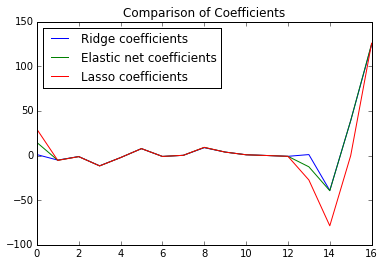

      Ridge R^2: 0.358518
      Lasso R^2: 0.359062
Elastic Net R^2: 0.358883


In [103]:
#plot the coefficients
plt.plot(R_coef, label='Ridge coefficients')
plt.plot(E_coef, label='Elastic net coefficients')
plt.plot(L_coef, label='Lasso coefficients')
plt.legend(loc='best')
plt.title("Comparison of Coefficients")
plt.show()

print ("      Ridge R^2: %f\n      Lasso R^2: %f\nElastic Net R^2: %f"
          % (R_score, L_score, E_score))

##ii) Polynomial Features

Polynomial Features genereates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.  
For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].  
(http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [104]:
# Polynomial Features
poly = preprocessing.PolynomialFeatures(2)
test_data_poly = poly.fit_transform(test_data)
dev_data_poly = poly.transform(dev_data) 
train_data_poly = poly.transform(train_data) 

print 'train data shape: ', train_data_poly.shape
print 'dev data shape: ', dev_data_poly.shape
print 'test data shape: ', test_data_poly.shape
print '\n'

# Train RidgeCV model using the training sets 
clf = linear_model.RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0])
clf.fit(train_data_poly, train_labels)

# Model Summary
output_model_summary(clf, dev_data_poly, dev_labels, test_data_poly, test_labels)


train data shape:  (7000, 171)
dev data shape:  (2000, 171)
test data shape:  (1825, 171)


Coefficients: 
[  0.00000000e+00   1.44887479e+01  -5.37002606e+01  -2.78026406e+01
   5.69972576e+01   1.34102226e+01  -7.75571657e+00   1.41489115e+00
   2.56016619e-01   5.86645976e-01   1.84829768e+01  -9.51157286e+00
  -1.26284112e+00   1.55651519e+00   1.44887479e+01  -2.93579157e+00
   2.93579157e+00  -5.91575731e+01  -8.37539727e+00   6.92452712e+01
   9.46754109e+00   2.28834118e+00  -1.65835755e+00   7.67237245e-01
  -3.65288512e-01  -3.39405068e-01   3.21018258e+01  -1.10301651e-01
   2.31014052e+00  -2.06015477e+00   8.83895939e+00  -8.37539727e+00
   5.91181134e+00   8.57693654e+00   4.69436773e-01  -5.37002606e+01
   0.00000000e+00   1.05129506e+01   1.91908832e+00   1.02258548e+00
  -3.66086520e-01   2.05137982e-01  -1.03762850e+02   1.35791167e-01
   4.85525060e+00   6.85369412e+00  -3.40399501e+01   6.92452712e+01
  -2.82232087e+01  -2.54770519e+01  -2.33696428e+01  -2.78026406e

In [106]:
# Kaggle Submission with Polynomial features
X1_poly = poly.transform(X1)
X_poly =  poly.transform(X)
clf.fit(X_poly, Y)
pred = clf.predict(X1_poly)


generate_kaggle_submission(pred, "submission_poly_ridge.csv")



Generating Kaggle Submission File: submission_poly_ridge.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
preds:  [ -9.17224369e+01  -3.85925822e+01  -7.98073585e+00 ...,  -5.46081945e+04
  -5.46323252e+04  -5.46542983e+04]
df_dt.head():                datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
df_dt.head():     count
0      0
1      0
2      0
3      6
4     31
Shape of Submission Dataframe:  (6493, 2)
output.head():               datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      6
4  2011-01-20 04:00:00     31


We are now at 3116. Oops - we are going the wrong way! We still have many more ideas.

##iii) SVR

Support Vector Regression performs classification by finding the hyperplane that maximizes the margin between classes. (http://www.saedsayad.com/support_vector_machine.htm)

One of the advantages of SVR is it can be used to avoid difficulties of using linear functions in high dimensional feature space. The loss function is used to penalize errors greater than the threshold.

In [49]:
svr = svm.SVR(kernel='linear')

# Train the model using the training sets
svr.fit(train_data, np.squeeze(train_labels))

# Model Summary
output_model_summary(svr, dev_data, dev_labels, test_data, test_labels)

Coefficients: 
[[-0.0108273  -0.05388881  0.01091433 -0.03555397  0.02008015 -0.06202439
   0.01414295 -0.00518587  0.00107309 -0.06944035 -0.0235859  -0.00375977
   0.01129483 -0.0108273   0.28990512 -0.28990512 -0.5225867 ]]

Intercept:  [ 3.10021306]
Residual sum of squares: 1.26
[DEV]  R^2 - Variance score: 0.39
[TEST] R^2 - Variance score: 0.40




In [52]:
# Kaggle Submission with SVR Linear
svr.fit(X, np.squeeze(Y))
pred = svr.predict(X1)
generate_kaggle_submission(pred, "submission_svr_linear.csv")



Generating Kaggle Submission File: submission_svr_linear.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
preds:  [ -26.58040956  -15.44692814   -9.91354987 ...,  199.05214977  215.02572031
  205.25527804]
df_dt.head():                datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
df_dt.head():     count
0      0
1      0
2      0
3      0
4     -0
Shape of Submission Dataframe:  (6493, 2)
output.head():               datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00     -0


Well, that took a while to run, but unfortunately we have no improvement. We are at 2921 now.

##iv) Side-Tracks

Before we go any farther, let's look at some different things we can do to help improve our score.

### a) Cross-Validation

With Cross Validation, we can shuffle split the data any number of times and specify how large the test size should be.  This means we can see how the model performs with multiple variations of the training and development data, and the data also does not need to be sliced in whole continuous chunck, as we use an index for identifying which data rows are used.


In [107]:
#  OLS with Cross Validation
ols = linear_model.LinearRegression()

#Here we define the ShuffleSplit, using 5 iterations, a test size of 25%
ss = cross_validation.ShuffleSplit(X.shape[0], n_iter=5, test_size=0.25, random_state=0)
count = 1

#Here we iterate through our 5 pairs of train and test data:
for train_index, test_index in ss:
    print("\n [Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))
    # Train the model using the training sets
    ols.fit(X[train_index], Y[train_index])

    # Model Summary
    output_model_summary(ols, X[test_index], Y[test_index])
    
    count += 1


 [Iteration:1] Num of Training: 8118,  Num of Test: 2707
Coefficients: 
[  1.13061603e+12   2.67205489e+00   1.80625057e+00  -9.02718422e+00
   2.17978495e+00   3.49985763e+00  -1.54148369e+00   1.50082365e-01
   1.40395396e+00   4.93777278e+00   1.03441807e+00   3.19033199e-01
  -4.07563539e-01  -1.13061603e+12   3.87812158e+08   3.87812239e+08
   1.48617729e+02]

Intercept:  -387812157.14
Residual sum of squares: 16439.61
[DEV]  R^2 - Variance score: 0.47



 [Iteration:2] Num of Training: 8118,  Num of Test: 2707
Coefficients: 
[ -5.47112997e+12  -4.33928383e+00   5.06230640e+00  -7.98673919e+00
  -6.67681581e-01   6.18177942e+00  -1.58787891e+00   2.32919479e-01
  -2.55084879e-01   4.85585405e+00   1.92878986e+00   4.17947586e-01
  -7.06038697e-01   5.47112997e+12   4.58861774e+09   4.58861782e+09
   1.48355703e+02]

Intercept:  -4588617740.32
Residual sum of squares: 15518.91
[DEV]  R^2 - Variance score: 0.47



 [Iteration:3] Num of Training: 8118,  Num of Test: 2707
Coefficient

### b) Multiple Models

To this point we have also been using all the data to test the models. As shown in the data analysis sections, there is a different pattern of use between casual and registered users.

We previously created variables X_R, Y_R and X1_R for registered users, and X_C, Y_C and X1_C for casual users (X1 is the Kaggle data set). All X_R and X_C have the same number of rows. The difference comes in which data features are used.

Let's try it using the simple linear regression model.

In [113]:
#create the data variables for registered users
test_r, test_r_labels = X_R[9000:], Y_R[9000:]
dev_r, dev_r_labels = X_R[7000:9000], Y_R[7000:9000]
train_r, train_r_labels = X_R[:7000], Y_R[:7000]

#create the data variables for casual users
test_c, test_c_labels = X_C[9000:], Y_C[9000:]
dev_c, dev_c_labels = X_C[7000:9000], Y_C[7000:9000]
train_c, train_c_labels = X_C[:7000], Y_C[:7000]

#create the data variables for casual users
test_c, test_c_labels = X_C[9000:], Y_C[9000:]
dev_c, dev_c_labels = X_C[7000:9000], Y_C[7000:9000]
train_c, train_c_labels = X_C[:7000], Y_C[:7000]

# RidgeCV classifiers
lr   = linear_model.RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0]) #all
lr_c = linear_model.RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0]) #casual
lr_r = linear_model.RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0]) #registered

# fit the models
lr.fit(train_data, train_labels)       #all
lr_c.fit(train_c, train_c_labels) #casual
lr_r.fit(train_r, train_r_labels) #registered

# get the predictions
pred = lr.predict(dev_data)        #all
pred_c = lr_c.predict(dev_c)  #casual
pred_r = lr_r.predict(dev_r)  #registered


print "All users [count]"
output_model_summary(lr, dev_data, dev_labels)
print "-" * 80
print "Registered users [registered]"
output_model_summary(lr_r, dev_r, dev_r_labels)
print "-" * 80
print "Casual users [casual]"
output_model_summary(lr_c, dev_c, dev_c_labels)

All users [count]
Coefficients: 
[  1.05632475e+00  -5.11264866e+00  -1.15530725e+00  -1.15363693e+01
  -2.33758213e+00   7.72861872e+00  -1.02068702e+00   2.25545134e-01
   8.80205573e+00   3.86911912e+00   8.47270969e-01   1.62238481e-02
  -8.95479609e-01   1.05632475e+00  -3.91383685e+01   3.91383685e+01
   1.24277851e+02]

Intercept:  19.0939808842
Residual sum of squares: 28421.61
[DEV]  R^2 - Variance score: 0.36


--------------------------------------------------------------------------------
Registered users [registered]
Coefficients: 
[ -2.03189452e+01  -2.32481288e+01   9.87345692e-02   3.36209314e+00
  -2.61978349e-01  -2.08606230e-01   3.36178786e+01   2.62539122e+01
  -1.47258069e+01  -4.51459840e+01   9.37789267e+00   4.11497458e+00
  -8.63070320e-02  -3.90369764e+01   5.38526049e+00   3.10717883e-01
   1.28914944e+00   6.18189764e-02  -5.90235426e+01  -4.47057556e+01
   2.38918796e+01   4.68303055e+01   4.78179415e+01  -1.48108284e+01
   8.97089598e+00   1.55646387e+01 

We end up with some really nice variance scores for Registered and Casual users in predicting the number of Registered and Casual users.

Since we know the Count for each hour is the sum of Registered and Casual, how do we do when we add our models together?

In [114]:
combined = pred_c + pred_r
print combined

# The mean square error
print ("\nResidual sum of squares: %.2f" % np.mean((np.rint(combined) - dev_labels) ** 2))
    
# Explained variance score: 1 is perfect prediction
slope, intercept, r_value, p_value, std_err = stats.linregress(combined,dev_labels)
print "R^2 - Variance score: %.2f" %r_value**2


[  69.45742091   76.3701408    47.89416541 ...,  328.95662182  340.07999343
  380.91115853]

Residual sum of squares: 17617.75
R^2 - Variance score: 0.70


We now have an R-squared of 0.70! 

Let's see what we get using two models with simple linear regression but with the full Kaggle data set.

In [115]:
# fit the models
lr_c.fit(X_C, Y_C) #casual
lr_r.fit(X_R, Y_R) #registered

# get the predictions
pred_c = lr_c.predict(X1_C)  #casual
pred_r = lr_r.predict(X1_R)  #registered
print pred_c
print pred_r
print pred_c + pred_r

generate_kaggle_submission(pred_c + pred_r, "multiple_models_linear.csv")

[-26.39384719 -18.85850567 -17.879251   ...,   5.00251715   8.58915986
   6.1791486 ]
[ -75.5531051   -61.92059174  -60.81961088 ...,  191.59017765  196.19502319
  194.17141492]
[-101.94695229  -80.77909741  -78.69886188 ...,  196.5926948   204.78418305
  200.35056352]


Generating Kaggle Submission File: multiple_models_linear.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
preds:  [-101.94695229  -80.77909741  -78.69886188 ...,  196.5926948   204.78418305
  200.35056352]
df_dt.head():                datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
df_dt.head():     count
0      0
1      0
2      0
3      0
4      0
Shape of Submission Dataframe:  (6493, 2)
output.head():               datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00      0


Ended up at 2392.  That is quite the improvement from 2995 for the Ridge classifier without the two models.


##iv) Random Forests

Random Forests proved to be our best option. Let's walk through this with a simple implementation first before moving into more complicated setups.

Before we start, let's refresh our data variables. Of note here, we take the log of the labels to assist in our 


"Logarithmically transforming variables in a regression model is a very common way to handle situations
where a non-linear relationship exists between the independent and dependent variables.
Using the logarithm of one or more variables instead of the un-logged form makes the effective
relationship non-linear, while still preserving the linear model."

In [121]:
TRAIN_FX = feature_extraction(TRAIN_OR)
KAGGLE_TEST_FX = feature_extraction(KAGGLE_TEST)

(features, features_r, features_c) = feature_selection()

Y_COUNT = np.log(TRAIN_FX['count'] + 1)

TRAIN_FX_FS_R = TRAIN_FX[features_r]
KAGGLE_TEST_FX_FS_R = KAGGLE_TEST_FX[features_r]
Y_R = np.log(TRAIN_FX['registered'] + 1)
X_R = TRAIN_FX_FS_R.values
X1_R = KAGGLE_TEST_FX_FS_R.values

TRAIN_FX_FS_C = TRAIN_FX[features_c]
KAGGLE_TEST_FX_FS_C = KAGGLE_TEST_FX[features_c]
Y_C = np.log(TRAIN_FX['casual'] + 1)
X_C = TRAIN_FX_FS_C.values
X1_C = KAGGLE_TEST_FX_FS_C.values

###a) Simple Random Forests
The first example uses the Cross Validation, but sticks to using only one model.

In [117]:
#  Random Forrest with Cross Validation
rf = ensemble.RandomForestRegressor(n_estimators=100)
ss = cross_validation.ShuffleSplit(X.shape[0], n_iter=5, test_size=0.25, random_state=0)
count = 1
for train_index, test_index in ss:
    print("[Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))
    # Train the model using the training sets
    rf.fit(X[train_index], Y[train_index])

    # Model Summary
    output_model_summary(rf, X[test_index], Y[test_index])
    
    count += 1

# Train the model using the entire data set
rf.fit(X, Y)
pred = rf.predict(X1)
generate_kaggle_submission(pred, "rf_simple.csv")

[Iteration:1] Num of Training: 8118,  Num of Test: 2707
Residual sum of squares: 1760.27
[DEV]  R^2 - Variance score: 0.94


[Iteration:2] Num of Training: 8118,  Num of Test: 2707
Residual sum of squares: 1541.24
[DEV]  R^2 - Variance score: 0.95


[Iteration:3] Num of Training: 8118,  Num of Test: 2707
Residual sum of squares: 1483.48
[DEV]  R^2 - Variance score: 0.95


[Iteration:4] Num of Training: 8118,  Num of Test: 2707
Residual sum of squares: 1544.11
[DEV]  R^2 - Variance score: 0.95


[Iteration:5] Num of Training: 8118,  Num of Test: 2707
Residual sum of squares: 1561.67
[DEV]  R^2 - Variance score: 0.95




Generating Kaggle Submission File: rf_simple.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
preds:  [  11.46    5.44    3.52 ...,  160.54  116.23   77.57]
df_dt.head():                datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
df_dt.head():     count
0

1249 - just like that! And we haven't even tried using multiple models!

###b) Add multiple models

Now we add Casual and Registered models:


[Iteration:1] Num of Training: 8118,  Num of Test: 2707
OOB Score (Registered, Casual): 0.96, 0.90
[TRAIN] Residual sum of squares (Count, Registered, Casual): 273.96, 190.92, 37.36
[TEST] Residual sum of squares (Count, Registered, Casual): 1744.25, 1211.02, 233.70
[TEST] R^2 - Variance score (Count, Registered, Casual): 0.93, 0.95, 0.90

[Iteration:2] Num of Training: 8118,  Num of Test: 2707
OOB Score (Registered, Casual): 0.95, 0.90
[TRAIN] Residual sum of squares (Count, Registered, Casual): 273.64, 190.50, 36.07
[TEST] Residual sum of squares (Count, Registered, Casual): 1637.61, 1167.60, 200.56
[TEST] R^2 - Variance score (Count, Registered, Casual): 0.93, 0.96, 0.90

[Iteration:3] Num of Training: 8118,  Num of Test: 2707
OOB Score (Registered, Casual): 0.95, 0.90
[TRAIN] Residual sum of squares (Count, Registered, Casual): 297.21, 208.74, 37.23
[TEST] Residual sum of squares (Count, Registered, Casual): 1637.22, 1144.52, 208.92
[TEST] R^2 - Variance score (Count, Registered, 

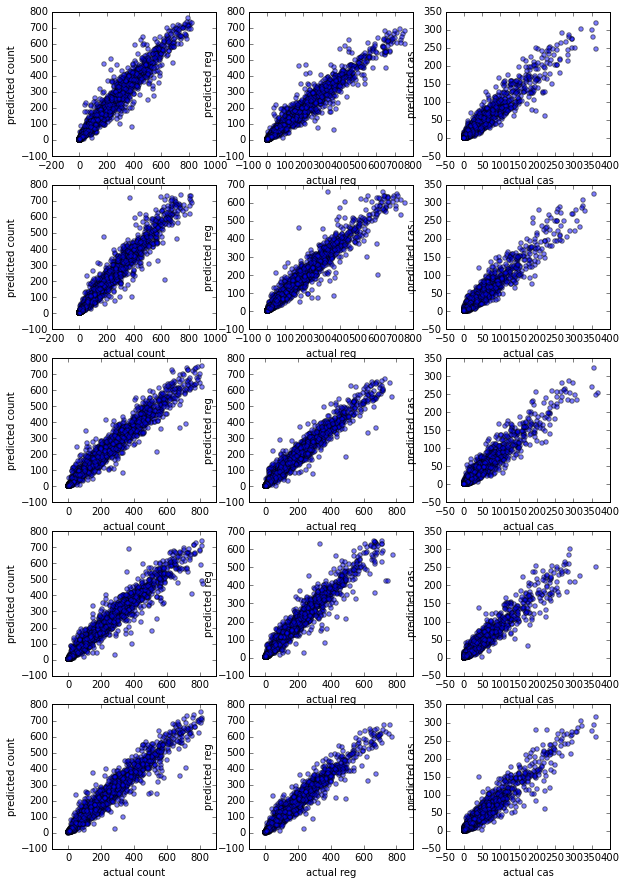

In [126]:
#  Random Forrest with Cross Validation
n_estimators = 200
max_features = 9
#sample_leaf_options = [1,5,10, 25, 50,100,200,500]
n_iter = 5
rows = n_iter
cols = 3
cnt = 1

fig = plt.figure(figsize=(10, 15), dpi=80)
ax1 = fig.add_subplot(rows, cols, cnt)

#Define the Regression Models
rf_reg = ensemble.RandomForestRegressor(n_estimators=n_estimators, 
                                        max_features=max_features,
                                        oob_score=True,
                                        n_jobs=-1)
rf_cas = ensemble.RandomForestRegressor(n_estimators=n_estimators, 
                                        max_features=max_features,
                                        oob_score=True,
                                        n_jobs=-1)

#the ShuffleSplit
ss = cross_validation.ShuffleSplit(X_R.shape[0], n_iter=n_iter, test_size=0.25, random_state=0)
count = 1

#Loop through the cross validations
for train_index, test_index in ss:
    print("\n[Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))

    # Train the model using the training sets
    rf_reg.fit(X_R[train_index], Y_R[train_index])

     # Train the model using the training sets
    rf_cas.fit(X_C[train_index], Y_C[train_index])

    # Train
    pred_reg_train = inv_log(rf_reg.predict(X_R[train_index]))
    pred_cas_train = inv_log(rf_cas.predict(X_C[train_index]))
    predictions_train = pred_reg_train + pred_cas_train

    # Test
    pred_reg = inv_log(rf_reg.predict(X_R[test_index]))
    pred_cas = inv_log(rf_cas.predict(X_C[test_index]))
    predictions = pred_reg + pred_cas
    
    
    ax1 = fig.add_subplot(rows, cols, cnt)
    ax1.set_xlabel("actual count")
    ax1.set_ylabel("predicted count")
    ax1.scatter(inv_log(Y_COUNT[test_index]), predictions, alpha=0.5)
    cnt += 1 
    
    ax2 = fig.add_subplot(rows, cols, cnt)
    ax2.set_xlabel("actual reg")
    ax2.set_ylabel("predicted reg")
    ax2.scatter(inv_log(Y_R[test_index]), pred_reg, alpha=0.5)
    cnt += 1 
    
    ax3 = fig.add_subplot(rows, cols, cnt)
    ax3.set_xlabel("actual cas")
    ax3.set_ylabel("predicted cas")
    ax3.scatter(inv_log(Y_C[test_index]), pred_cas, alpha=0.5)
    cnt += 1 
    
    print ("OOB Score (Registered, Casual): %.2f, %.2f" % (rf_reg.oob_score_, rf_cas.oob_score_))
    
    # The mean square error
    ss_r = np.mean((np.rint(pred_reg_train) - inv_log(Y_R[train_index])) ** 2)
    ss_c = np.mean((np.rint(pred_cas_train) - inv_log(Y_C[train_index])) ** 2)
    ss = np.mean((np.rint(predictions_train) - inv_log(Y_COUNT[train_index])) ** 2)
    print("[TRAIN] Residual sum of squares (Count, Registered, Casual): %.2f, %.2f, %.2f"
          % (ss, ss_r, ss_c))
    
    ss_r = np.mean((np.rint(pred_reg) - inv_log(Y_R[test_index])) ** 2)
    ss_c = np.mean((np.rint(pred_cas) - inv_log(Y_C[test_index])) ** 2)
    ss = np.mean((np.rint(predictions) - inv_log(Y_COUNT[test_index])) ** 2)
    print("[TEST] Residual sum of squares (Count, Registered, Casual): %.2f, %.2f, %.2f"
          % (ss, ss_r, ss_c))
    
    # Explained variance score: 1 is perfect prediction
    r_squared_r = rf_reg.score(X_R[test_index], Y_R[test_index])
    r_squared_c = rf_cas.score(X_C[test_index], Y_C[test_index])
    r_squared = ( r_squared_r +  r_squared_c) / 2
    print('[TEST] R^2 - Variance score (Count, Registered, Casual): %.2f, %.2f, %.2f' % (r_squared, r_squared_r, r_squared_c))

    count += 1
    



Let's see how well this does in Kaggle.  As a bonus, let's take a closer look at the feature rankings.



[Registered] Feature ranking:
1. Feature 15 - hour : (0.471845)
2. Feature 18 - hour_0_3 : (0.097732)
3. Feature 27 - peakhours : (0.088136)
4. Feature 19 - hour_4_7 : (0.049889)
5. Feature 25 - year_month : (0.037865)
6. Feature 16 - day : (0.031660)
7. Feature 22 - hour_16_19 : (0.028134)
8. Feature 1 - workingday : (0.026645)
9. Feature 17 - dayofyear : (0.024630)
10. Feature 5 - humidity : (0.021147)
11. Feature 3 - atemp : (0.020645)
12. Feature 2 - temp : (0.018074)
13. Feature 24 - year : (0.014330)
14. Feature 14 - month : (0.010683)
15. Feature 21 - hour_12_15 : (0.009588)
16. Feature 4 - windspeed : (0.008470)
17. Feature 8 - weather3 : (0.007617)
18. Feature 20 - hour_8_11 : (0.006161)
19. Feature 26 - sunday : (0.006080)
20. Feature 0 - season : (0.005739)
21. Feature 23 - hour_20_23 : (0.005432)
22. Feature 10 - temp1 : (0.004120)
23. Feature 6 - weather1 : (0.001992)
24. Feature 7 - weather2 : (0.001513)
25. Feature 11 - temp2 : (0.001208)
26. Feature 12 - temp3 : (0.00

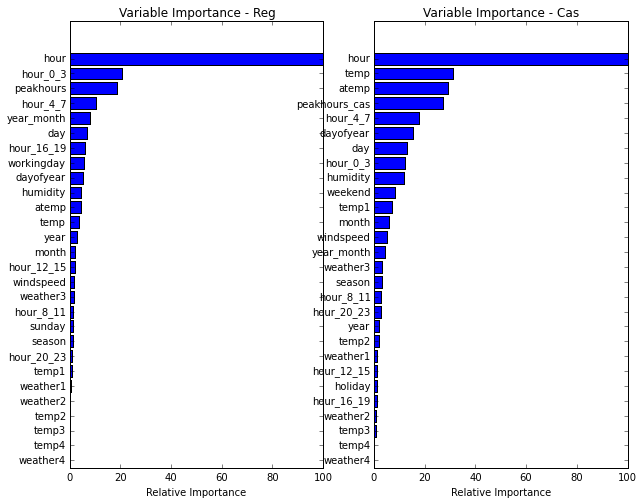



Generating Kaggle Submission File: rf_multipleModel.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
preds:  [   9.19278703    5.42181338    2.9921104  ...,  145.71781414  113.80087115
   73.49848304]
df_dt.head():                datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
df_dt.head():     count
0      9
1      5
2      3
3      2
4      2
Shape of Submission Dataframe:  (6493, 2)
output.head():               datetime  count
0  2011-01-20 00:00:00      9
1  2011-01-20 01:00:00      5
2  2011-01-20 02:00:00      3
3  2011-01-20 03:00:00      2
4  2011-01-20 04:00:00      2


In [129]:
# Train the model using the entire data set (Used to generate Kaggle Submission Later)
rf_reg.fit(X_R, Y_R)
rf_cas.fit(X_C, Y_C)

feature_importances__reg = rf_reg.feature_importances_
#print feature_importances__reg
indices = np.argsort(feature_importances__reg)[::-1]

# Print the feature ranking
print("\n\n[Registered] Feature ranking:")
for f in xrange(len(features_r)):
    print("%d. Feature %d - %s : (%f)" % (f + 1, indices[f],  features_r[indices[f]], feature_importances__reg[indices[f]]))
    
    
feature_importances__cas = rf_cas.feature_importances_
#print feature_importances__cas
indices = np.argsort(feature_importances__cas)[::-1]

# Print the feature ranking
print("\n\n[Casual] Feature ranking:")
for f in xrange(len(features_c)):
    print("%d. Feature %d - %s : (%f)" % (f + 1, indices[f],  features_c[indices[f]], feature_importances__cas[indices[f]]))
    
# Plot feature importance
fig = plt.figure(figsize=(10, 8), dpi=80)
# make importances relative to max importance
feature_importances__reg = 100.0 * (feature_importances__reg / feature_importances__reg.max())
sorted_idx = np.argsort(feature_importances__reg)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importances__reg[sorted_idx], align='center')
plt.yticks(pos, np.array(features_r)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance - Reg')

# make importances relative to max importance
feature_importances__cas = 100.0 * (feature_importances__cas / feature_importances__cas.max())
sorted_idx = np.argsort(feature_importances__cas)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importances__cas[sorted_idx], align='center')
plt.yticks(pos, np.array(features_c)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance - Cas')
plt.show()


pred_reg = inv_log(rf_reg.predict(X1_R))
pred_cas = inv_log(rf_cas.predict(X1_C))
predictions = pred_reg + pred_cas

# Kaggle Submission
generate_kaggle_submission(predictions, "rf_multipleModel.csv")

Now we're getting somewhere - 471!

----
##BEST RESULT
We were stuck here for a while, then with a stroke of luck (also known as Rajesh), we produced this result. Due to the way it was found, I will repeat some code here to ensure it is replicated exactly how it was implemented.

###DATA IMPORT

In [131]:
dfs = {}

# import training data set
train_df = pd.read_csv('train.csv')
train_df['_data'] = 'train'
dfs['train'] = train_df

# import test data set
test_df = pd.read_csv('test.csv')
test_df['_data'] = 'test'
dfs['test'] = test_df

# combine train and test data
combined_df = dfs['train'].append(dfs['test'])

# lowercase column names
combined_df.columns = map(str.lower, combined_df.columns)

###TRANSFORM DATA

In [132]:
# parse datetime column & add new time related columns
dt = pd.DatetimeIndex(combined_df['datetime'])
combined_df.set_index(dt, inplace=True)

# create new columns for day, month, year, hour
combined_df['date'] = dt.date
combined_df['day'] = dt.day
combined_df['month'] = dt.month
combined_df['year'] = dt.year
combined_df['hour'] = dt.hour
combined_df['dayofweek'] = dt.dayofweek
# creating new columns transforming bike ridership to log
for column in ['casual', 'registered', 'count']:
    combined_df['%s_log' % column] = np.log(combined_df[column] + 1)
# mark peak hours
#combined_df['peak'] = combined_df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

# mark peak hours
# sat/sun - 10am to 7pm
# mon-fri - 6am to 10am | 4pm to 7pm
combined_df['peak'] = 0
combined_df['peak'][(
        ( (combined_df['workingday'] == 0 ) & ( (combined_df['hour'] >= 10) & (combined_df['hour'] <= 19) ) ) |
        ( 
            (combined_df['workingday'] == 1 ) & 
            ( 
               ( (combined_df['hour'] >= 6) & (combined_df['hour'] <= 10) ) | 
               ( (combined_df['hour'] >= 16) & (combined_df['hour'] <= 19) )
            )
        )
    )] = 1

/home/angela/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [134]:
# define perfect weather and humid weather variables
combined_df['perfect'] = combined_df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
combined_df['humid'] = combined_df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
combined_df.head()

,_data,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,...,month,year,hour,dayofweek,casual_log,registered_log,count_log,peak,perfect,humid
2011-01-01 00:00:00,train,14.395,3,16,2011-01-01 00:00:00,0,81,13,1,9.84,...,1,2011,0,5,1.386294,2.639057,2.833213,0,0,0
2011-01-01 01:00:00,train,13.635,8,40,2011-01-01 01:00:00,0,80,32,1,9.02,...,1,2011,1,5,2.197225,3.496508,3.713572,0,0,0
2011-01-01 02:00:00,train,13.635,5,32,2011-01-01 02:00:00,0,80,27,1,9.02,...,1,2011,2,5,1.791759,3.332205,3.496508,0,0,0
2011-01-01 03:00:00,train,14.395,3,13,2011-01-01 03:00:00,0,75,10,1,9.84,...,1,2011,3,5,1.386294,2.397895,2.639057,0,0,0
2011-01-01 04:00:00,train,14.395,0,1,2011-01-01 04:00:00,0,75,1,1,9.84,...,1,2011,4,5,0.000000,0.693147,0.693147,0,0,0


###UTILITY FUNCTIONS

In [135]:
# get training data
def get_train_data():
    train_data = combined_df[combined_df['_data'] == 'train'].copy()
    return train_data

# get test data
def get_test_data():
    test_data = combined_df[combined_df['_data'] == 'test'].copy()
    return test_data

# split train and test data
def split_train_test(df, cutoff_day = 15):
    train_data = df[df['day'] <= cutoff_day]
    test_data = df[df['day'] > cutoff_day]

    return train_data, test_data

# prepare data for training the model
def prepare_data(df, features):
    X = df[features].as_matrix()
    Y_reg = df['registered_log'].as_matrix()
    Y_cas = df['casual_log'].as_matrix()

    return X, Y_reg, Y_cas

In [136]:
#function make_kaggle_submission
# purpose: make the kaggle file for submission (with Rajesh's extra touches)
# predictions: the list of predictions
# file_name: the file name
def make_kaggle_submission(predictions, file_name):
    print "-" * 80

    # check shape of the test and prediction sets
    print "Generating file for Kaggle Submission File: %s" % (file_name)
    print "Shape of Kaggle Test Data: ", FINAL_TEST_DF.shape
    print "Shape of Kaggle Test Predictions: ", predictions.shape  

    # formatting predictions to integers and removing negative values
    predictions = np.rint(predictions)
    predictions[ predictions < 0] = 0
    print predictions
    
    print "Shape of Final Predictions: ", predictions.shape

    # create submission file
    #sbmt_file_name = [os.getcwd(),'../submissions/',file_name]
    sbmt_file_name = file_name
    np.savetxt(sbmt_file_name, zip(FINAL_TEST_DF['datetime'], predictions), delimiter=',', fmt="%s", header=','.join(['datetime','count']), comments='')
    print "kaggle submission file generated"

###PREDICTION ALGORITHMS

In [137]:
#function predict_validation_data
# purpose: prediction on validation data
# model: the model to be used (the classifier)
# features: featues to be used
# return: predictions, test (not log values), and score
def predict_validation_data(model, features):
    df = get_train_data()

    train, test = split_train_test(df)

    X_train, Y_train_reg, Y_train_cas = prepare_data(train, features)
    X_test, Y_test_reg, Y_test_cas = prepare_data(test, features)

    # predict registered users count
    model_reg = model.fit(X_train, Y_train_reg)
    Y_prd_reg = np.exp(model_reg.predict(X_test)) - 1

    # predict casual users count
    model_cas = model.fit(X_train, Y_train_cas)
    Y_prd_cas = np.exp(model_cas.predict(X_test)) - 1

    # combine registered and casual user predictions
    Y_prd = np.round(Y_prd_reg + Y_prd_cas)
    Y_prd[Y_prd < 0] = 0

    # transform predictions back from log
    Y_test = np.exp(Y_test_reg) + np.exp(Y_test_cas) - 2

    score = RMSLE_score(Y_prd, Y_test)
    return (Y_prd, Y_test, score)


#function predict_validation_data
# purpose: predict Kaggle test data & transform output
# model: the model to be used (the classifier)
# features: featues to be used
# returns: the predictions
def predict_kaggle_data(model, features):
    # get train and test data
    train_df = get_train_data()
    test_df = get_test_data()

    # prepare training data
    X_train, Y_train_reg, Y_train_cas = prepare_data(train_df, features)

    # prepare test data
    X_test = test_df[features].as_matrix()

    # predict casual users count
    model_cas = model.fit(X_train, Y_train_cas)
    Y_prd_cas = np.exp(model_cas.predict(X_test)) - 1
    
    # predict registered users count
    model_reg = model.fit(X_train, Y_train_reg)
    Y_prd_reg = np.exp(model_reg.predict(X_test)) - 1

    # combine casual & registered predictions together
    Y_prd = np.round(Y_prd_reg + Y_prd_cas)
    Y_prd[Y_prd < 0] = 0
    
    return Y_prd

###Random Forest Regression

In [138]:
params = {
    'n_estimators': 1000, 
    'max_depth': 15, 
    'random_state': 0, 
    'min_samples_split' : 5, 
    'n_jobs': -1}

rf_model = RandomForestRegressor(**params)
rf_features = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'humid',
    'hour', 'dayofweek', 'peak'
    ]

(rf_prd, rf_test, rf_score) = predict_validation_data(rf_model, rf_features)
print rf_score

0.45145158864


###Gradient Boost

In [140]:
params = {
    'n_estimators': 150, 
    'max_depth': 5, 
    'random_state': 0, 
    'min_samples_leaf' : 10, 
    'learning_rate': 0.1, 
    'subsample': 0.7, 
    'loss': 'ls'}

gbm_model = GradientBoostingRegressor(**params)
gbm_features = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'humidity',
    'hour', 'dayofweek', 'year', 'perfect'
]

(gbm_prd, gbm_test, gbm_score) = predict_validation_data(gbm_model, gbm_features)
print gbm_score

0.320439613069


In [141]:
# combine predictions from both the models
# random forest and gradient boost
y_prd = np.round(.2 * rf_prd + .8 * gbm_prd)
print RMSLE_score(y_prd, rf_test)

0.324481864995


###PREDICTIONS ON KAGGLE DATASET

In [142]:
# predict on Kaggle data using random forest
rf_prd = predict_kaggle_data(rf_model, rf_features)

# predict on Kaggle data using gradient boost
gbm_prd = predict_kaggle_data(gbm_model, gbm_features)

# combine predictions from both the models
# random forest and gradient boost
output = np.round(.2 * rf_prd + .8 * gbm_prd)

FINAL_TEST_DF = get_test_data()
make_kaggle_submission(output, 'combine_random_forest_grad_boost.csv')

--------------------------------------------------------------------------------
Generating file for Kaggle Submission File: combine_random_forest_grad_boost.csv
Shape of Kaggle Test Data:  (6493, 25)
Shape of Kaggle Test Predictions:  (6493,)
[ 12.   5.   3. ...,  99.  80.  42.]
Shape of Final Predictions:  (6493,)
kaggle submission file generated


The result is (drumroll please):
##                            22
Yes - that is the ranking of this little bit of code! 

----

# Rolling Data 

Okay, as exciting as it is to get the 22nd best score, there is one rule we have been ignoring. 

> You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

So here we will present a simple rolling system and then show it using our best model from before.

In [ ]:
## Simple Rolling Data

